In [2]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import re
import datetime as dt

In [92]:
#Settings
pd.set_option('display.max_columns', 50)
pd.set_option('precision', 2)
%matplotlib inline

In [93]:
#Read data, set date_recorded as "datetime".
dat = pd.read_csv('../data/water_pump/training.csv', header=0,
                  parse_dates=['date_recorded'])

In [94]:
labels = pd.read_csv('../data/water_pump/training_labels.csv',
                     header=0)

#join labels to dat on "id" (left outer)
dat = dat.merge(labels, how='left', left_on='id', right_on='id',
                copy=False)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null datetime64[ns]
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null 

In [95]:
dat.sample(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
12911,64143,0.0,2011-07-19,Dw,1733,DWE,31.27,-7.60,Matembo,0,Lake Rukwa,Utulivu 1,Rukwa,15,3,Nkasi,Chala,1,NaN,GeoData Consultants Ltd,VWC,NaN,False,1986,gravity,gravity,gravity,vwc,user-group,unknown,unknown,unknown,unknown,unknown,unknown,river,river/lake,surface,communal standpipe,communal standpipe,non functional
18607,17225,200.0,2013-03-22,Kkkt Church,646,KKKT CHURCH,37.91,-4.50,Kwa Amai,0,Pangani,Mbuyuni B,Kilimanjaro,3,3,Same,Hedaru,180,True,GeoData Consultants Ltd,Water authority,Hedaru kati water supply,True,2011,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
9196,41685,0.0,2011-03-08,Musilim Agency,315,Local technician,38.60,-4.96,Mjohoroni 2,0,Pangani,Kibandaukindu,Tanga,4,2,Korogwe,Kerenge,400,True,GeoData Consultants Ltd,VWC,NaN,False,2010,afridev,afridev,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
2177,8495,0.0,2011-03-21,Government Of Tanzania,292,RWE,36.86,-7.95,Kwazanyolo,0,Rufiji,Bwawani,Morogoro,5,3,Kilombero,Kiberege,300,True,GeoData Consultants Ltd,NaN,NaN,True,1985,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
7233,10098,30.0,2011-03-19,Government Of Tanzania,432,WD and ID,38.26,-5.75,Kwa Safatuma,7,Pangani,Kwedikome,Tanga,4,6,Handeni,Mazingara,200,True,GeoData Consultants Ltd,VWC,WD and ID,False,1970,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe,non functional


In [96]:
dat.shape

(59400, 41)

#### OUTCOME VARIABLE CLASS PROPORTIONS
We can see on the graph below that class "functional needs repair" is severely imbalanced (`< 10%` of dataset).

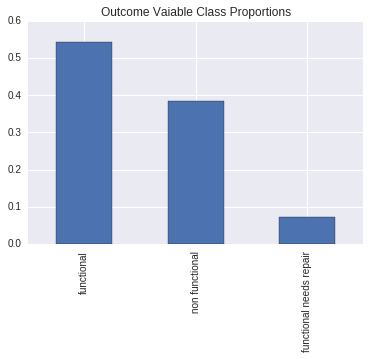

In [97]:
dat.status_group.value_counts(normalize=True).plot(kind='bar');
plt.title('Outcome Vaiable Class Proportions');

#### TIME ANALYSIS
Not a time series, readings are sporadic, there are gaps in years.

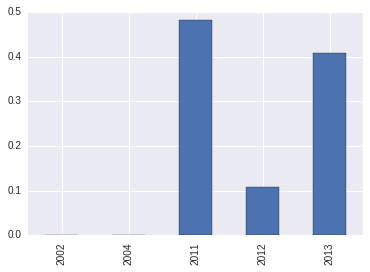

In [98]:
#dat['date_recorded']=pd.to_datetime(dat.date_recorded)
dat['year']=dat.date_recorded.dt.year

#2004 and 2002 datapoints; <1% of the dataset combined
dat.year.value_counts(normalize=True).sort_index().plot(kind='bar');

#####  Checking out outcome variable proportion by year reading taken:

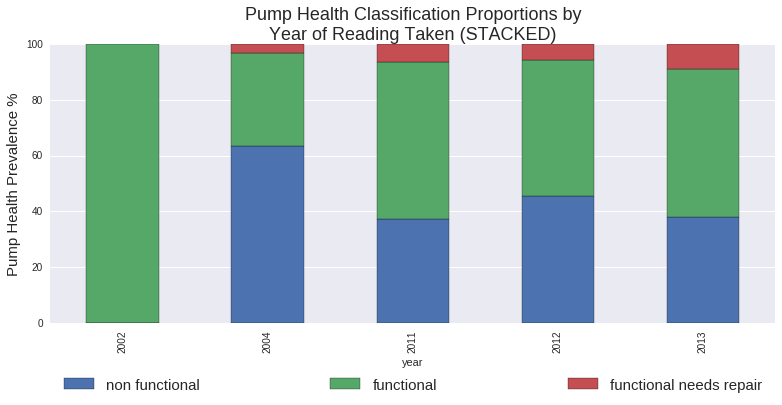

In [99]:
# Compute a simple cross-tabulation of status_group vs year
# Than tranform in percentile
temp = pd.crosstab(dat.status_group, dat.year).apply(
    lambda col: ((col / col.sum()).round(3)) * 100, axis=0)

# Rename indexes.
temp = temp.reindex(['non functional', 'functional',
                     'functional needs repair'])

temp.transpose().plot(kind='bar',legend='status_group',
                      stacked=True, figsize=(13,5))

# Add title and labels
plt.title('\n'.join(['Pump Health Classification Proportions by',
                     'Year of Reading Taken (STACKED)']),
          fontsize=18
         )
plt.ylabel( 'Pump Health Prevalence %', fontsize=15)
plt.legend(mode="expand", loc=1, ncol=3, fontsize=15,
           bbox_to_anchor=(0., -0.25, 1., .102));

# Delete temp to free memory
del temp

We see that 2002 is misleading in its classification distribution
 (Only 1 data point in 2002). Suggest removing that.

#### Checking out Pump health proportion by construction years:

In [100]:
# Compute a simple cross-tabulation of status_group vs year
# Than tranform in percentile
temp1 = pd.crosstab(dat.status_group, dat.construction_year).apply(
    lambda col: ((col / col.sum()).round(3)) * 100, axis=0)

# rename indexes
temp1 = temp1.reindex(['non functional', 'functional',
                       'functional needs repair'])
temp1

construction_year,0,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
status_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
non functional,40.4,70.6,76.2,73.3,56.5,80.0,36.8,64.7,45.5,66.2,69.5,72.3,39.3,65.3,65.8,59.6,57.7,66.9,64.4,49.6,72.4,60.8,59.7,61.0,57.4,...,43.4,45.0,51.2,37.2,47.5,42.7,34.1,46.5,44.4,34.9,24.3,32.3,31.9,30.2,30.1,31.1,34.0,30.8,24.6,24.8,24.5,20.1,18.7,28.3,41.5
functional,51.0,23.5,9.5,23.3,36.5,17.5,57.9,35.3,35.2,28.6,25.4,24.1,56.6,25.1,29.9,34.6,33.0,20.5,30.7,41.1,21.4,31.8,35.7,31.7,38.3,...,52.2,48.8,43.5,56.4,46.9,51.5,58.5,47.6,45.2,56.1,70.9,61.2,61.3,64.4,64.4,62.7,57.2,60.0,68.1,70.4,70.0,76.5,75.1,67.0,58.0
functional needs repair,8.6,5.9,14.3,3.3,7.1,2.5,5.3,0.0,19.3,5.2,5.1,3.6,4.1,9.6,4.3,5.8,9.4,12.6,5.0,9.4,6.2,7.4,4.6,7.3,4.3,...,4.4,6.2,5.2,6.4,5.6,5.8,7.4,5.9,10.4,9.0,4.8,6.5,6.9,5.4,5.5,6.2,8.8,9.2,7.3,4.9,5.4,3.4,6.2,4.7,0.6


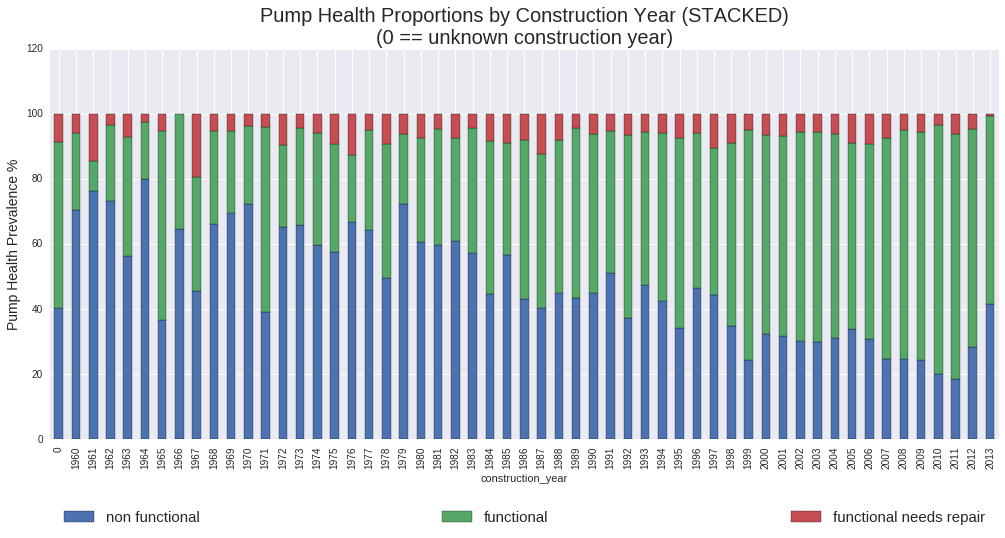

In [85]:
fig, ax = plt.subplots(1,1, figsize=(17,7))
temp1.transpose().plot(kind='bar', legend='status_group', stacked=True, ax=ax)
#temp1.iloc[1,:].plot(kind='bar', color='green', ax=ax, legend='status_group', bottom=temp1.iloc[0,:])
#temp1.iloc[2,:].plot(kind='bar', color='red', ax=ax, legend='status_group')

# Add Titles and labels
ax.set_ylabel('Pump Health Prevalence %', fontsize=14)
ax.set_title('\n'.join(['Pump Health Proportions by Construction Year (STACKED)',
                        '(0 == unknown construction year)']),
            fontsize=20)
ax.legend(mode="expand", loc=1, ncol=3,
          bbox_to_anchor=(0., -0.25, 1., .102),
          fontsize=15
          );

The graph above shows, not surprisingly, that older pumps breakdown a lot more than the newer ones. There is also the '0' group which grouped missing construction year. 
`Pumps needing repair` are more or less evenly spread out by `age of pump`. This facts suggest either that newer pumps breakdown less, or that maintenance is better lately, or both.

In [135]:
#what % of "construction years" are missing?
print('The percentage of construction years missing is %4.2f%%' %
      (100 * dat[dat.construction_year==0].shape[0] / dat.shape[0])
     )

The percentage of construction years missing is 34.86%


#### NUMERIC VARIABLES ANALYSIS

In [136]:
pd.set_option('precision', 2)
dat.describe(include=['int64','float64','float32']) 
#coded categoricals also show up

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year
count,59400.00,59400.00,59400.00,59400.00,5.94e+04,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00
mean,37115.13,317.65,668.30,34.08,-5.71e+00,0.47,15.30,5.63,179.91,1300.65,2011.92
std,21453.13,2997.57,693.12,6.57,2.95e+00,12.24,17.59,9.63,471.48,951.62,0.96
min,0.00,0.00,-90.00,0.00,-1.16e+01,0.00,1.00,0.00,0.00,0.00,2002.00
25%,18519.75,0.00,0.00,33.09,-8.54e+00,0.00,5.00,2.00,0.00,0.00,2011.00
50%,37061.50,0.00,369.00,34.91,-5.02e+00,0.00,12.00,3.00,25.00,1986.00,2012.00
75%,55656.50,20.00,1319.25,37.18,-3.33e+00,0.00,17.00,5.00,215.00,2004.00,2013.00
max,74247.00,350000.00,2770.00,40.35,-2.00e-08,1776.00,99.00,80.00,30500.00,2013.00,2013.00


#### TAKING A LOOK AT DISTRIBUTIONS OF CONTINUOUS VARIABLES, SEGMENTED BY STATUS_GROUP (pump health)

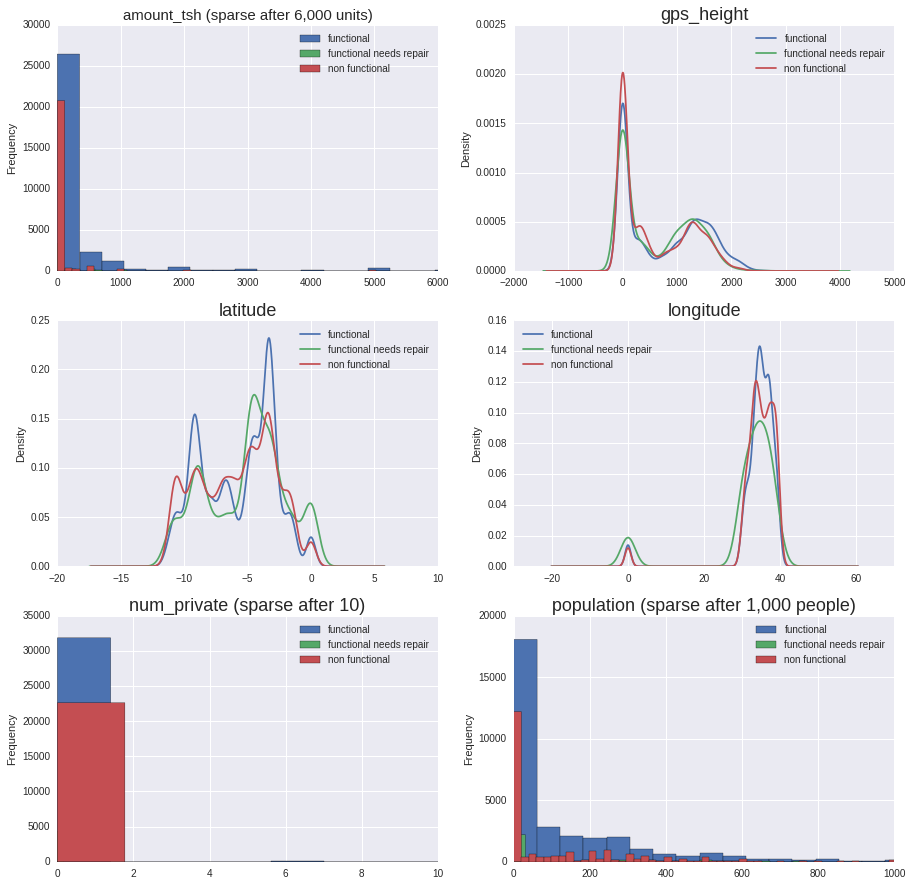

In [137]:
#create figure and axis
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(
    nrows=3, ncols=2, figsize=(15,15))

# Group by status_group
g = dat.groupby(dat.status_group)

#total static head (amount water available to waterpoint)
g['amount_tsh'].plot.hist(ax=ax1,legend=True,
                          bins=1000, xlim=(0,6000))
ax1.set_title('amount_tsh (sparse after 6,000 units)', fontsize=15)

#Altitude of the well
g['gps_height'].plot(kind='kde', ax=ax2,legend=True)
ax2.set_title('gps_height', fontsize=18) 

g['latitude'].plot(kind='kde',ax=ax3,legend=True)
ax3.set_title('latitude', fontsize=18)

g['longitude'].plot(kind='kde',ax=ax4,legend=True)
ax4.set_title('longitude', fontsize=18)

#no desc
g['num_private'].plot.hist(ax=ax5,legend=True,
                           bins=1000, xlim=(0,10))
ax5.set_title('num_private (sparse after 10)', fontsize=18)

 #pop around the well
g['population'].plot.hist(ax=ax6,legend=True,
                          bins=500, xlim=(0,1000))
ax6.set_title('population (sparse after 1,000 people)', fontsize=18)

# Delete temporaty object
g = None

**GPS height**: more readings at lower altitudes; more repairs seems to be needed at higher heights   
**latitude**: higher lats (North) see less readings, more non functionals and repairs; mid-lats have healthiest data
**longitude**: more or less normally distributed readings going from east to west; 

need separate and deeper look at location parameters

In [138]:
#% of missing num_private values
print('Percentage of missing num_private values %4.2f%%' % 
      (100 * dat[dat.num_private==0].shape[0] / dat.shape[0]))

Percentage of missing num_private values 98.73%


In [139]:
#% of missing population values
round(len(dat[dat.population==0])/float(len(dat)),3)*100

36.0

In [1]:
#closer look at data
sns.pairplot(dat.loc[:,['amount_tsh','num_private','population','gps_height','status_group']], 
              hue="status_group",
              size=5)


NameError: name 'sns' is not defined

In [ ]:
#too many missing values in num_private and amount_tsh, hard to infer anything. Remove and insert lat, long for some location analysis
sns.pairplot(dat.loc[:,['population','gps_height','status_group','latitude','longitude']], 
              hue="status_group",
              size=5)

In [ ]:
#okay, population densities and water pumps increase around North-Mid to North-West areas; still hard to see relationships.
#let's go 3D with lat, long, and gps-height; by pump health

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=dat.loc[dat.status_group.isin(['functional']),'latitude'],
           ys=dat.loc[dat.status_group.isin(['functional']),'longitude'],
           zs=dat.loc[dat.status_group.isin(['functional']),'gps_height'],
           c='blue',
           marker='.',
           s=144,
          label='functional')
ax.scatter(xs=dat.loc[dat.status_group.isin(['non functional']),'latitude'],
           ys=dat.loc[dat.status_group.isin(['non functional']),'longitude'],
           zs=dat.loc[dat.status_group.isin(['non functional']),'gps_height'],
           c='green',
           marker='x',
           alpha=0.75,
          s=34,
          label='non functional')
ax.scatter(xs=dat.loc[dat.status_group.isin(['functional needs repair']),'latitude'],
           ys=dat.loc[dat.status_group.isin(['functional needs repair']),'longitude'],
           zs=dat.loc[dat.status_group.isin(['functional needs repair']),'gps_height'],
           c='red',
           marker='^',
           alpha=0.5,
          s=21,
          label='functional needs repair')
ax.set_xlabel('latitude, South <--> North')
ax.set_ylabel('longitude, East <--> West')
ax.set_zlabel('pump height above sea level')
#ax.xy_dataLim([-14,30],[0,50])
#ax.ylim(10,50)
#ax.zlim(-500,2500)
ax.legend()
ax.set_title('3D Plot of Water Pump Heights by Tanzanian Latitudes and Longitudes')

# Inserting some additional analysis (some may be redundant)

In [ ]:
import pandas as pd

training_labels_df = pd.read_csv('../data/water_pump/training_labels.csv', header=0)
training_values_df = pd.read_csv('../data/water_pump/training.csv', header=0)

#training_labels_df = pd.read_csv(training_labels_file)
#training_values_df = pd.read_csv(training_values_file)

training_values_df['status_group'] = training_labels_df['status_group']

# Look at pump status with respect to geographical location

In [ ]:
# separate data by status of pump
func_df = training_values_df[training_values_df['status_group']=='functional']
nonfunc_df = training_values_df[training_values_df['status_group']=='non functional']
repair_df = training_values_df[training_values_df['status_group']=='functional needs repair']

# plot pump status on coordinate grid
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.plot(func_df.longitude,func_df.latitude,'g.')
plt.plot(nonfunc_df.longitude,nonfunc_df.latitude,'r.')
plt.plot(repair_df.longitude,repair_df.latitude,'y.')
plt.legend(['Functional','Non-functional','Needs repairs'])
plt.axis([27,43,-12,0])
plt.grid(True)

plt.figure(figsize=(20,10))
plt.plot(func_df.longitude,func_df.latitude,'g.')
plt.legend(['Functional'])
plt.axis([27,43,-12,0])
plt.grid(True)

plt.figure(figsize=(20,10))
plt.plot(nonfunc_df.longitude,nonfunc_df.latitude,'r.')
plt.legend(['Non-functional'])
plt.axis([27,43,-12,0])
plt.grid(True)

plt.figure(figsize=(20,10))
plt.plot(repair_df.longitude,repair_df.latitude,'y.')
plt.legend(['Needs repairs'])
plt.axis([27,43,-12,0])
plt.grid(True)

# Show status_group rates for various categorical features
Categorical features that look like good candidates from this (some of these may be redundant):
**basin, region, region_code, district_code, lga, public_meeting, scheme_management, permit, construction_year, extraction_type, extraction_type_group, management, management_group, payment, payment_type, water_quality,  quality_group, quantity_group, source, source_type, waterpoint_type, waterpoint_type_group 

Others that may be possible:
**funder, ward, scheme_name, source_class, 

In [ ]:
def calc_percentage(x):
    vals = x.status_group.values
    total = len(vals)
    perc_func = (vals == 'functional').sum() / float(total)
    perc_nonfunc = (vals == 'non functional').sum() / float(total)
    perc_repair = (vals == 'functional needs repair').sum() / float(total)
    
    return pd.DataFrame([[total, perc_func,perc_nonfunc,perc_repair]],
                        columns=['total','functional','non functional','functional needs repair'])

In [ ]:
from IPython.display import display

df_dict = {}

indices = ['funder','installer','wpt_name','basin', 'subvillage', 'region', 'region_code', 'district_code',
           'lga', 'ward', 'public_meeting', 'recorded_by','scheme_management', 'scheme_name', 'permit', 
           'construction_year','extraction_type', 'extraction_type_group', 'extraction_type_class','management', 
           'management_group', u'payment', u'payment_type','water_quality', 'quality_group', 'quantity','quantity_group',
           'source', u'source_type', u'source_class', u'waterpoint_type','waterpoint_type_group']
for idx in indices:
    df = training_values_df.groupby([idx]).apply(calc_percentage).sort_values('functional')
    display(df)
    df_dict[idx] = df

# Histograms

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

var_names_list = ['amount_tsh','gps_height','num_private','population']
max_val_list = [10000,-1,25,-1,-1,5000,-1]
bins_list = [100,100,100,100,100,100,100]

cols = ['variable','perc_zero_func','perc_zero_nonfunc','perc_zero_repair','unique_vals']
summary_df = pd.DataFrame([],columns=cols)

variable_list = zip(var_names_list,max_val_list,bins_list)

for var,max_val,num_bins in variable_list:
    
    num_vals = len(set(training_values_df[var].values))
    
    func_df = training_values_df[training_values_df['status_group']=='functional']
    nonfunc_df = training_values_df[training_values_df['status_group']=='non functional']
    repair_df = training_values_df[training_values_df['status_group']=='functional needs repair']

    temp_df = pd.DataFrame([[var,
                            1.0*(func_df[var] == 0).sum() / len(func_df),
                            1.0*(nonfunc_df[var] == 0).sum() / len(nonfunc_df),
                            1.0*(repair_df[var] == 0).sum() / len(repair_df),
                            num_vals]],
                           columns=cols)
                            
    summary_df = summary_df.append(temp_df,ignore_index=True)
    if max_val > -1:
        func_df[func_df[var]>max_val] = max_val
        nonfunc_df[nonfunc_df[var]>max_val] = max_val
        repair_df[repair_df[var]>max_val] = max_val

    plt.figure(figsize=(20,10))

    sns.distplot(func_df[var],bins=num_bins)
    sns.distplot(nonfunc_df[var],bins=num_bins)
    sns.distplot(repair_df[var],bins=num_bins)
    plt.title(var + ' histograms',fontsize=20)
    plt.ylabel(var)
    plt.legend(['Functional', 'Non functional','Needs repair'])

summary_df

In [ ]:
#funder
dat['funder']=dat['funder'].astype('category',copy=False)

In [ ]:
dat.funder.value_counts(normalize=True).head(20).plot(kind='bar', figsize=(15,5))
plt.title('Frequency of "Funder" Categories in Dataset: Top 20')
#Top 20-ish funders get close to making up about 50% of the dataset

In [ ]:
dat.funder.sample(5)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sbrn.distplot(dat.gps_height, kde=True, rug=False)
#sbrn.boxplot(dat.gps_height, ax=ax2)



In [ ]:
sbrn.pairplot(dat, hue="status_group",size=5, diag_kind='kde')

In [ ]:
dat.source